In [1]:
import os, re, glob
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, QED, Draw
from rdkit.ML.Cluster import Butina
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.preprocessing import MinMaxScaler

### Section 1 — Collect DiffDock rank-1 poses
This section scans all subfolders of `diffdock_results/`, loads the top‐ranked pose (`rank1_confidence.sdf`)
for each ligand, and extracts:
- `CID` (ligand identifier)
- `SMILES` representation
- `confidence` score from filename or SDF tag.

**Logic for selecting the poses**
- DiffDock ranks all poses by their confidence level , where:
    - c > 0 high confidence
    - -1.5 < c < 0 moderate confidence
    - c < -1.5 low confidence
 - Additionally, it also writes the sdf files as :
    - rank1.sdf, rank1_confidence<c-value>.sdf
    - rank2_confidence<c-value>.sdf and so on to chosen N poses, where N is chosen by the user
 - The following workflow only uses the confidence score - proximity with the co-crystal ligand pose

***Note*** : Due to the lack of time and GPU unavalibility, not all ligands to finish with Diffdock. At this moment 155/205 have finished, hence this analysis is roughly based on those. 

In [2]:
# ---------- 1. Collect best poses and confidence ----------
results_dir = "/home/pchatterjee/Documents/git/vs_workflow/DiffDock/diffdock_run/data/diffdock_results"
pose_files = glob.glob(f"{results_dir}/*/rank1_confidence*.sdf")

records = []
for sdf in pose_files:
    cid = os.path.basename(os.path.dirname(sdf))
    m = next(iter(Chem.SDMolSupplier(sdf, removeHs=False)), None)
    if not m:
        continue

    # Extract confidence value (handles +/- and decimals)
    conf = None
    match = re.search(r"confidence([+-]?\d*\.?\d+)", os.path.basename(sdf))
    if match:
        conf = float(match.group(1))
    elif m.HasProp("confidence"):
        conf = float(m.GetProp("confidence"))

    smi = Chem.MolToSmiles(Chem.RemoveHs(m))
    records.append({"CID": cid, "SMILES": smi, "confidence": conf})

print(f"Loaded {len(records)} rank1 poses.")

df = pd.DataFrame(records).dropna(subset=["SMILES"])
df["confidence"] = df["confidence"].astype(float)

Loaded 155 rank1 poses.


### Section 2 — Compute ADME-related molecular properties
Using RDKit, calculate key drug-likeness metrics for each ligand:
- **LE** (Ligand Efficiency)
- **nRotB** (Rotatable Bonds)
- **logS** (Predicted solubility via ESOL model)
- **QED** (Quantitative Estimate of Drug-likeness)

These properties will later be combined with confidence scores for multi-criteria ranking.

In [3]:
# ---------- 2. Compute basic molecular properties ----------
def calc_esol_logS(mol):
    MW = Descriptors.MolWt(mol)
    logP = Descriptors.MolLogP(mol)
    rotB = Lipinski.NumRotatableBonds(mol)
    AromRings = rdMolDescriptors.CalcNumAromaticRings(mol)
    nRings = rdMolDescriptors.CalcNumRings(mol)
    AromProp = AromRings / nRings if nRings else 0
    return 0.16 - 0.63*logP - 0.0062*MW + 0.066*rotB - 0.74*AromProp

def calc_props(smi, conf):
    m = Chem.MolFromSmiles(smi)
    if not m: return pd.Series([None]*4, index=['LE','nRotB','logS','QED'])
    n_heavy = m.GetNumHeavyAtoms()
    LE = abs(conf) / n_heavy if n_heavy else None
    return pd.Series([
        LE,
        Lipinski.NumRotatableBonds(m),
        calc_esol_logS(m),
        QED.qed(m)
    ], index=['LE','nRotB','logS','QED'])

df = pd.concat([df, df.apply(lambda r: calc_props(r.SMILES, r.confidence), axis=1)], axis=1)

# ---------- 3. Rank ligands by confidence ----------
df_sorted = df.sort_values("confidence", ascending=False).reset_index(drop=True)
print("Top 50 by confidence:")
display(df_sorted.head(50))

Top 50 by confidence:


,CID,SMILES,confidence,LE,nRotB,logS,QED
0,Z16226232,O=C([C]Sc1nnc2[nH]c3[c][c][c][c]c3n12)N[C]1[C]...,0.93,0.040435,4.0,-2.451825,0.692331
1,Z16226176,O=C([C]Sc1nnc2[nH]c3[c][c][c][c]c3n12)N[C][C]1...,0.83,0.034583,5.0,-2.511506,0.534884
2,Z25402869,O=C([C]Sc1nnc(Nc2[c][c][c][c][c]2)s1)N[C]1[C][...,0.46,0.017037,6.0,-3.552368,0.641813
3,Z1514091612,[C]Oc1[c][c][c][c]c1[C]N([C][C]1[C][C][C]O1)c1...,0.46,0.018400,6.0,-2.708966,0.691829
4,Z442313918,[C]Oc1[c][c]c(-c2nc(Nc3[c][c][c][c][c]3)[nH]c(...,0.32,0.013333,4.0,-2.957004,0.755045
5,Z2832196726,O=S(=O)(c1[c][nH]c2n[c]n[c]c12)N([C][C]1[C][C]...,0.31,0.012917,5.0,-2.349832,0.689958
6,Z1013695804,Fc1[c][c]c(Nc2nc(N3[C][C][C][C][C]3)c3n[c][c]n...,0.30,0.012500,3.0,-2.892464,0.785234
7,5329551,Fc1[c][c][c]c(NC2=NC3=N[C]N[C]3C(O[C][C]3[C][C...,0.28,0.011200,3.0,-2.326538,0.863829
8,Z3807133138,O=C(c1[c][c][c]c2n[c][nH]c12)N1[C][C][C](Nc2n[...,0.23,0.009583,3.0,-2.912759,0.750258
9,COLIG_2A6,[C]1[C][C][C]([C]OC2=NC(Nc3[c][c][c][c][c]3)=N...,0.20,0.008333,3.0,-1.995237,0.851514


In [4]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', 1000)Q
# df_sorted[(df_sorted.CID == 'Z16226232' )].SMILES

#### Great Confidence/Pose Might Not Mean "Great Candidate" :
**Z16226232** : Green  
**2A6 X-ray pose** : Cyan Blue 

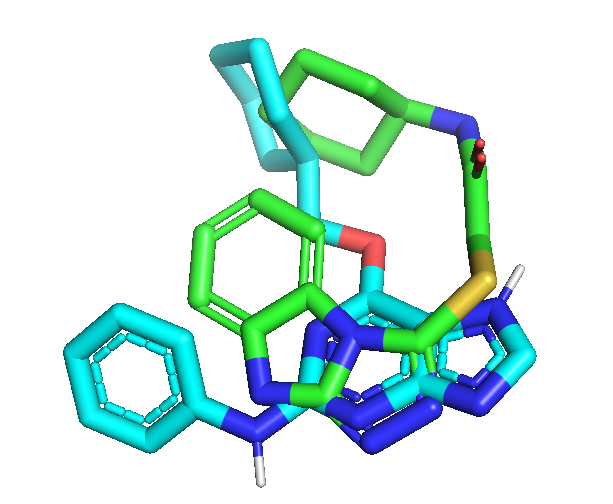


- Although Z16226232 core overalys somewhat well, despite being a 3 membered ring , as opposed to the purine core of 2A6, it might not mean a good candidate
- Note that the 3 membered heteroaromatic rings also overlays well with the Hinge binding Hydrogen bond donor an dacceptor duo, found in hinge binders
- Hence it is important to consider pose alignment as well as physicochemical/ADMET properties before final selection for purchase.                           
                       


## **Section 3 — Rank Order Centroid (ROC) -weighted ranking**

##### **About Rank Order Centroid (ROC) Weighting Method** :
The **Rank Order Centroid (ROC)** method converts qualitative rankings of metric importance into quantitative weights that sum to 1.  
If there are *n* criteria ranked by importance, the weight for criterion *j* is:

$$
w_j = \frac{1}{n} \sum_{k=j}^{n} \frac{1}{k}
$$

ROC was used here to objectively combine multiple ligand evaluation metrics  : (**confidence**, **LE**, **QED**, **logS**, **nRotB**) into a single composite score.  
It avoids arbitrary weighting and ensures more important criteria contribute proportionally more to the overall rank.

**Reference:**  
Barron, F. H., & Barrett, B. E. (1996). *Decision quality using ranked attribute weights.*  
**Management Science, 42(11), 1515–1523.** [https://doi.org/10.1287/mnsc.42.11.1515](https://doi.org/10.1287/mnsc.42.11.1515)



#### **Apply a Rank Order Centroid (ROC) weighting method to integrate multiple metrics into a composite score**.  
Steps:
1. Normalize all metrics to 0–1 scale (benefit vs. cost direction).
2. Assign ROC weights by decreasing metric importance.
3. Compute the composite `ROC_score` for each ligand.
Higher `ROC_score` = better compromise between confidence and ADME quality.


In [5]:
# ---------- 3. ROC ranking ----------
criteria = ["confidence", "LE", "QED", "logS", "nRotB"]
benefit = ["confidence", "LE", "QED", "logS"]  # higher = better
cost = ["nRotB"]                              # lower = better

# --- ROC Weights ---
n = len(criteria)
weights = [sum(1/k for k in range(j, n+1))/n for j in range(1, n+1)]
weights = [w/sum(weights) for w in weights]
roc_weights = dict(zip(criteria, weights))

# --- Normalize each metric 0–1 ---
scaler = MinMaxScaler()
for col in benefit:
    df[col + "_norm"] = scaler.fit_transform(df[[col]])
for col in cost:
    df[col + "_norm"] = 1 - scaler.fit_transform(df[[col]])

# --- Composite ROC score ---
df["ROC_score"] = 0
for col, w in roc_weights.items():
    df["ROC_score"] += df[col + "_norm"] * w

df_sorted = df.sort_values("ROC_score", ascending=False).reset_index(drop=True)

In [6]:
# === CONTINUE from ADME property calculation ===
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define top_df explicitly from df
top_df = df.copy()

#print("Before:", top_df.columns.tolist())


benefit = ["confidence", "LE", "QED", "logS"]  # higher = better
cost    = ["nRotB"]                             # lower = better

# --- Normalize values to [0,1] ---
scaler = MinMaxScaler()
for col in benefit:
    top_df[col + "_norm"] = scaler.fit_transform(top_df[[col]])
for col in cost:
    top_df[col + "_norm"] = 1 - scaler.fit_transform(top_df[[col]])

# --- Rank Order Centroid Weights ---
criteria = ["confidence", "LE", "QED", "logS", "nRotB"]
n = len(criteria)
weights = [sum(1/k for k in range(j, n+1))/n for j in range(1, n+1)]
weights = np.array(weights) / np.sum(weights)
roc_weights = dict(zip(criteria, weights))

print("\nROC Weights:")
for k,v in roc_weights.items():
    print(f"{k:10s}: {v:.3f}")

# --- Compute Composite ROC_score ---
top_df["ROC_score"] = 0.0
for col, w in roc_weights.items():
    top_df["ROC_score"] += top_df[col + "_norm"] * w

#print("Added ROC_score column.")
#print(top_df[["CID","ROC_score","confidence","LE","QED","logS","nRotB"]].head())

#print("After:", top_df.columns.tolist())


ROC Weights:
confidence: 0.457
LE        : 0.257
QED       : 0.157
logS      : 0.090
nRotB     : 0.040


### Interpretation from ROC Scores
- Note how the ROC scores have considered confidence scores as well as other properties such as QED and LogS
- Hence, the final selections will be made based on all these criteria

## Section 4 : Visualize top-ranked ligands
Display the top-N ligands (default: 25) in a grid view using RDKit’s `Draw.MolsToGridImage`.
Each cell shows the compound ID with its ROC and confidence score.


#### **Step 4 Summary** :
- Most top ranked depicted below have a confidence score > 0 --> meaning high confidence
- Compound ID 5329551 and 49863196 was one of the closest analog to the co crystal ligand 2A6
- Also, COLIG_2A6 - docked pose also showed up as one of the top ranking compounds (Note that this was only included for qualitative purposes)


In [7]:
df_sorted.columns

Index(['CID', 'SMILES', 'confidence', 'LE', 'nRotB', 'logS', 'QED',
       'confidence_norm', 'LE_norm', 'QED_norm', 'logS_norm', 'nRotB_norm',
       'ROC_score'],
      dtype='object')

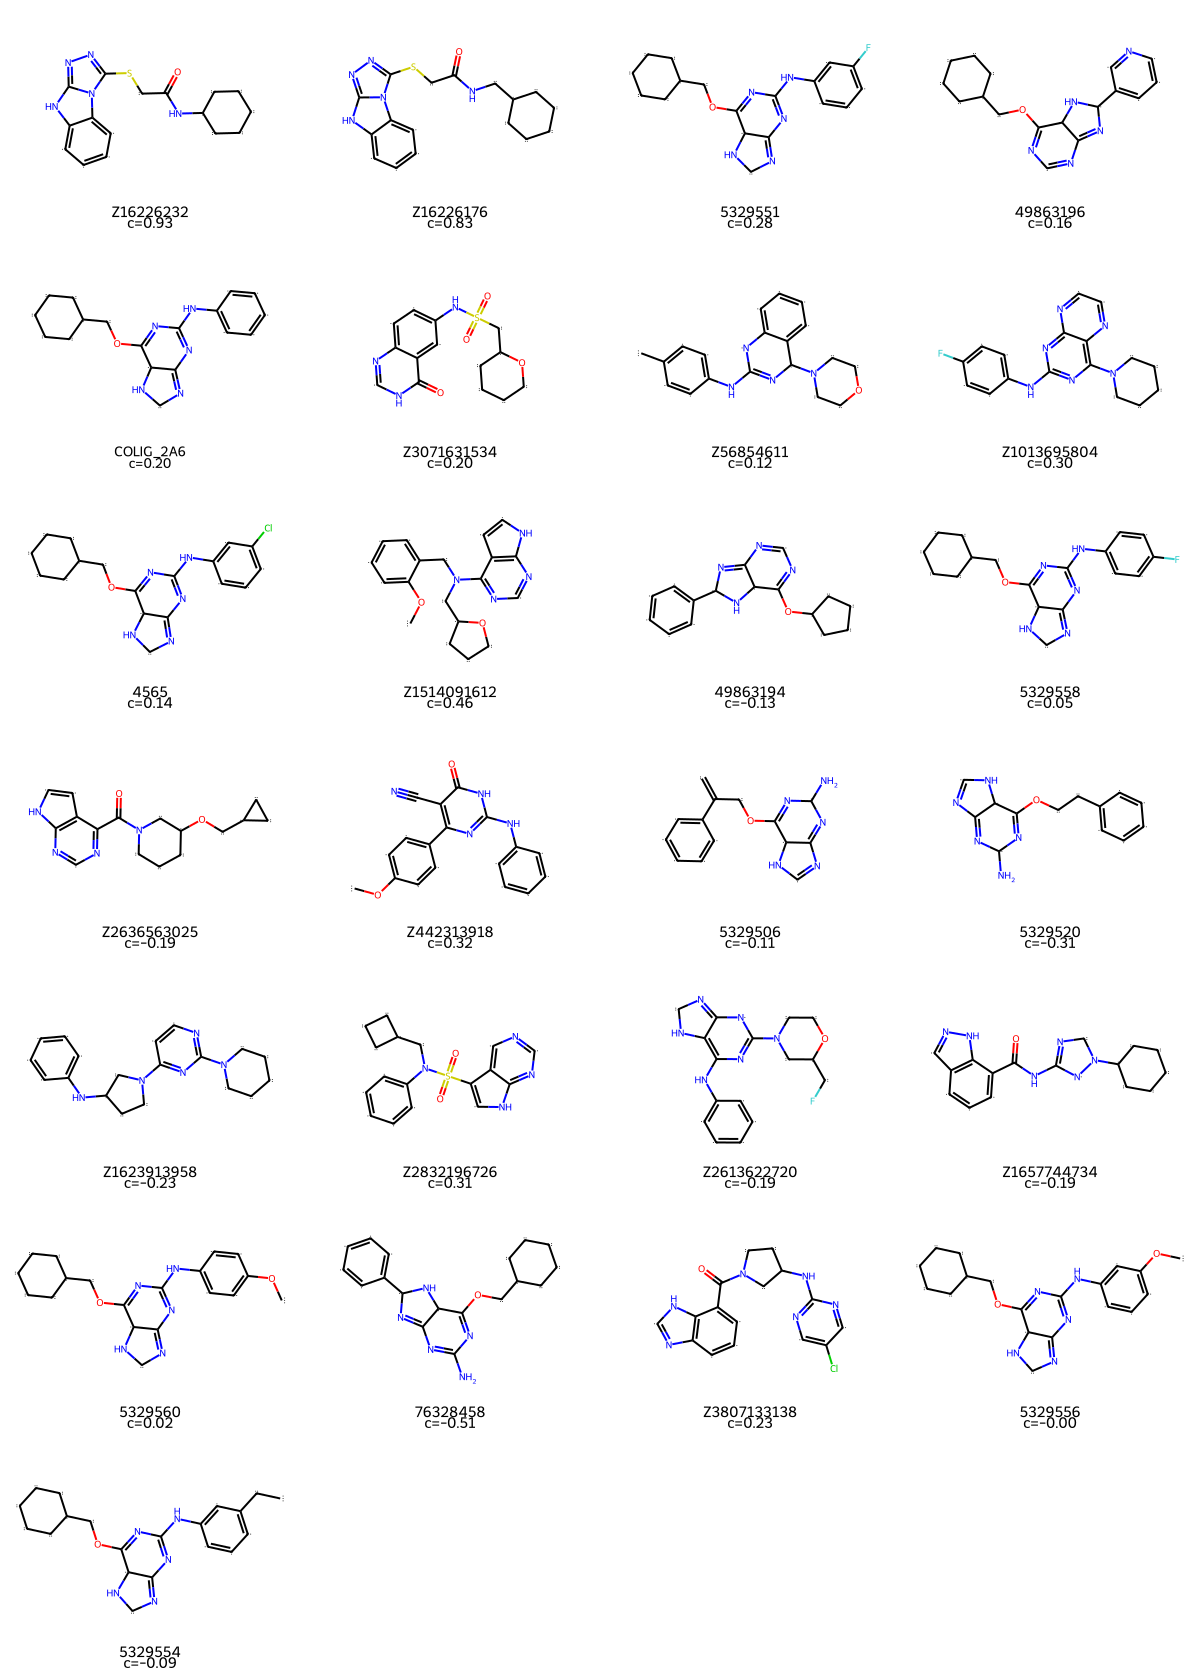

In [8]:
# ---------- 4. Visualize top molecules ----------
TOP_N, N_COLS = 25, 4
top_df = df_sorted.head(TOP_N)
mols = [Chem.MolFromSmiles(s) for s in top_df.SMILES]
for m in mols: Chem.rdDepictor.Compute2DCoords(m)
legends = [f"{cid}\nc={c:.2f}" for cid, c in zip(top_df.CID, top_df.confidence)]
img = Draw.MolsToGridImage(mols, molsPerRow=N_COLS, subImgSize=(300,240), legends=legends, maxMols=100)
display(img)

In [9]:
top_df.columns

Index(['CID', 'SMILES', 'confidence', 'LE', 'nRotB', 'logS', 'QED',
       'confidence_norm', 'LE_norm', 'QED_norm', 'logS_norm', 'nRotB_norm',
       'ROC_score'],
      dtype='object')

## Step 5 : Clustering of Top Ligands

- To identify **chemically diverse hits** among the top-ranked DiffDock ligands, the workflow generated **Morgan (ECFP-like) fingerprints** and applied **Butina clustering** based on pairwise **Tanimoto similarity**.
- Each ligand’s circular fingerprint captures its topological features, allowing structural grouping without relying on 3D pose alignment.  
- A **Tanimoto distance cutoff of 0.6** was used to define clusters - ligands within a cluster share ≥ 0.4 similarity.

- For each cluster, we computed:
        - **Number of members**
        - **List of compound IDs**
        - **Mean confidence score** (DiffDock’s ranking metric)

- This step enables selection of **representative ligands** from distinct chemotypes for subsequent ADME analysis or rescoring.
             - The Tanimoto similarity between two ligands *A* and *B* is defined as:

                    $$
                    T(A,B) = \frac{|A \cap B|}{|A \cup B|}
                    $$

  where \(T = 1\) indicates identical fingerprints and \(T = 0\) indicates no shared features.


In [10]:
# ---------- 5. Cluster top ligands ----------
fpgen = GetMorganGenerator(radius=2, fpSize=2048)
fps = [fpgen.GetFingerprint(Chem.MolFromSmiles(s)) for s in top_df.SMILES]
# Tanimoto distances
dists=[]
for i in range(1,len(fps)):
    sims=DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
    dists.extend([1-x for x in sims])
clusters=Butina.ClusterData(dists,len(fps),0.6,isDistData=True)
print(f"Formed {len(clusters)} clusters.")

summary=[]
for i,cl in enumerate(clusters,1):
    members=top_df.iloc[list(cl)]
    summary.append({"Cluster_ID":i,
                    "Num":len(cl),
                    "CIDs":", ".join(members.CID),
                    "MeanConf":members.confidence.mean()})
summary_df=pd.DataFrame(summary)
display(summary_df)

Formed 15 clusters.


,Cluster_ID,Num,CIDs,MeanConf
0,1,8,"COLIG_2A6, 5329551, 4565, 5329558, 5329560, 76...",0.01125
1,2,2,"49863194, 49863196",0.01500
2,3,2,"5329520, 5329506",-0.21000
3,4,2,"Z16226176, Z16226232",0.88000
4,5,1,Z3807133138,0.23000
5,6,1,Z1657744734,-0.19000
6,7,1,Z2613622720,-0.19000
7,8,1,Z2832196726,0.31000
8,9,1,Z1623913958,-0.23000
9,10,1,Z442313918,0.32000


## Step 6 : Cluster Summary

- Most PubChem analogs of the colig 2A6, which were DiffDock hits appeared in the same cluster 1 with 8 members
- The 2nd cluster was also the PubChem Cluster - which were also analogs of the co-crystal structure
- Note that clusters are not ranked as per the average ROC/Confidence score , although that could be good in practice , with a caveat that some members of the same cluster might not have high scores even though the structures are similar --> this happens in actual drug disovery campaigns too, where subtle changes lead to large SAR gap.
- **Hence the next step will be selection of the top candidates**


Cluster 1 — 8 members, mean confidence=0.01


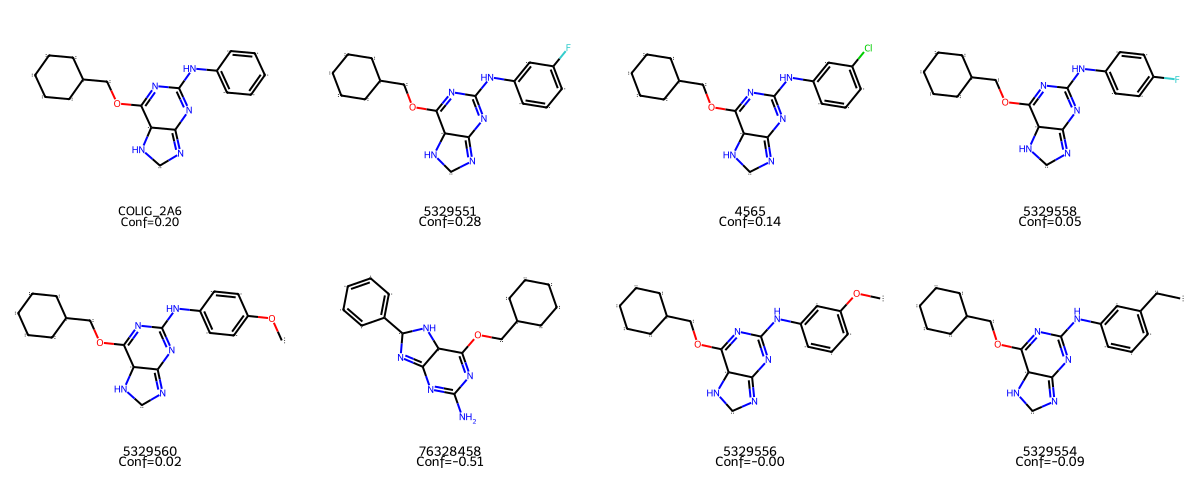


Cluster 2 — 2 members, mean confidence=0.01


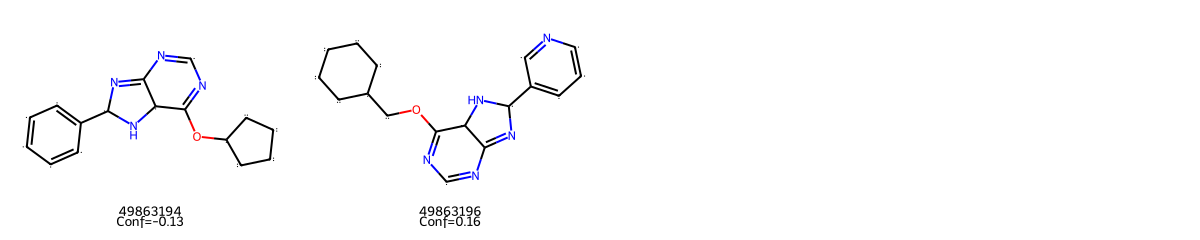


Cluster 3 — 2 members, mean confidence=-0.21


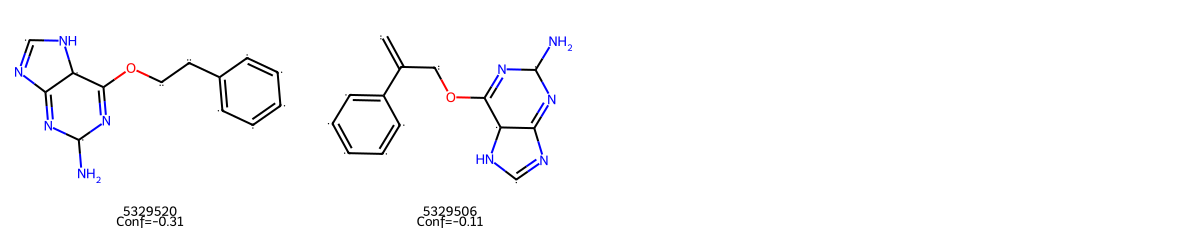


Cluster 4 — 2 members, mean confidence=0.88


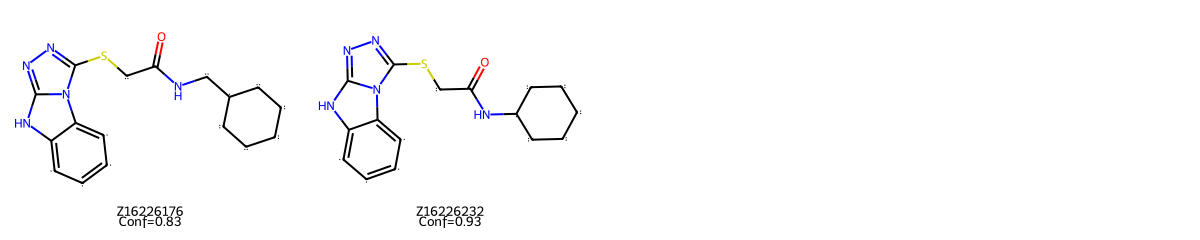


Cluster 5 — 1 members, mean confidence=0.23


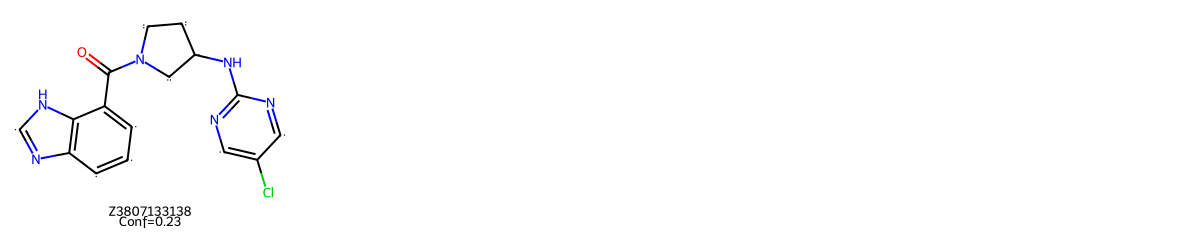


Cluster 6 — 1 members, mean confidence=-0.19


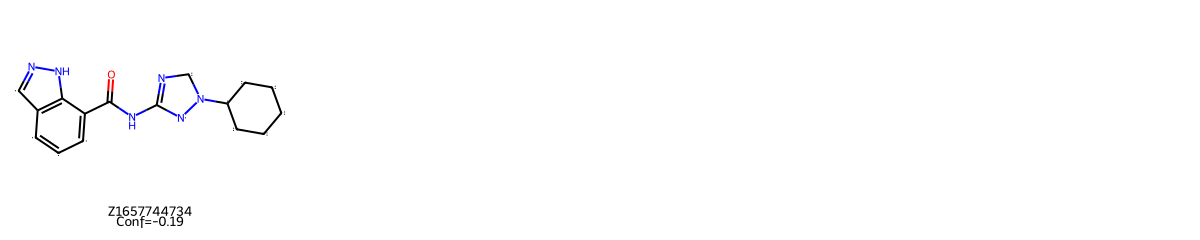


Cluster 7 — 1 members, mean confidence=-0.19


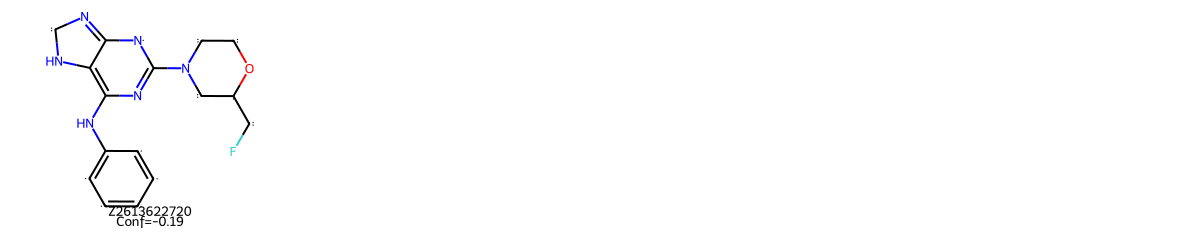


Cluster 8 — 1 members, mean confidence=0.31


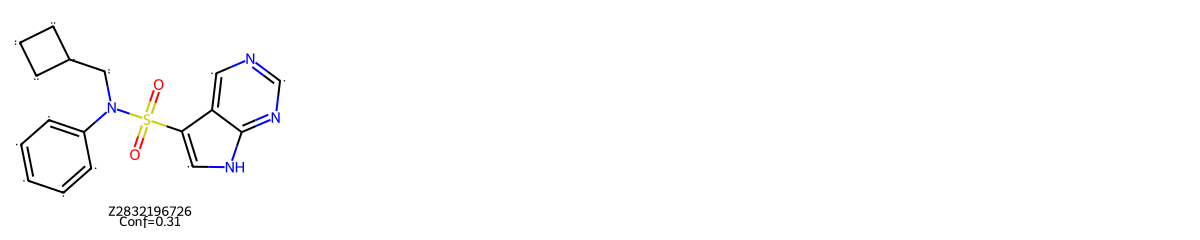


Cluster 9 — 1 members, mean confidence=-0.23


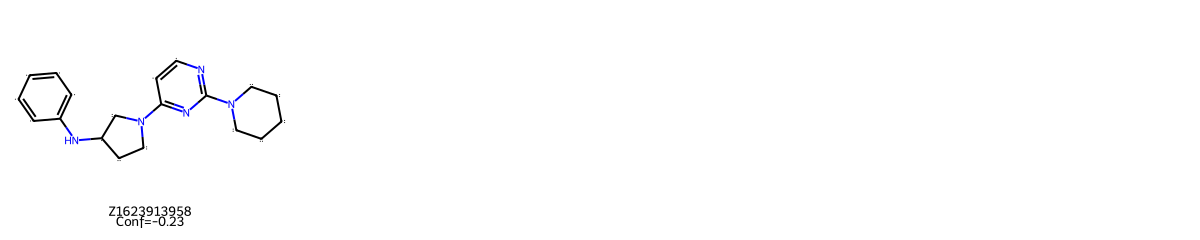


Cluster 10 — 1 members, mean confidence=0.32


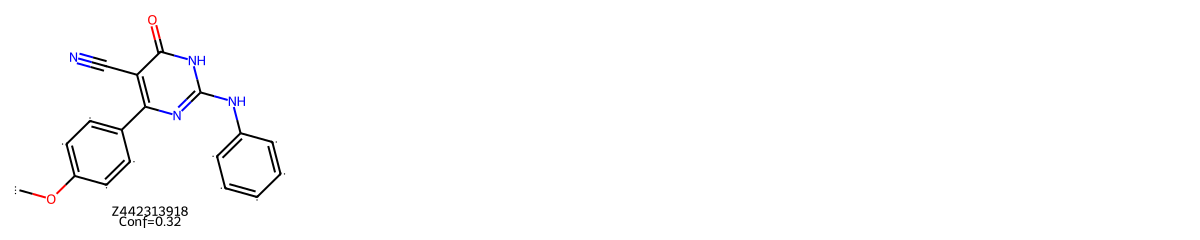


Cluster 11 — 1 members, mean confidence=-0.19


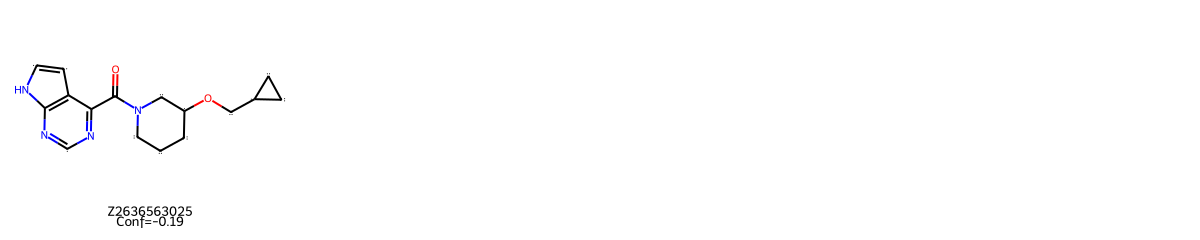


Cluster 12 — 1 members, mean confidence=0.46


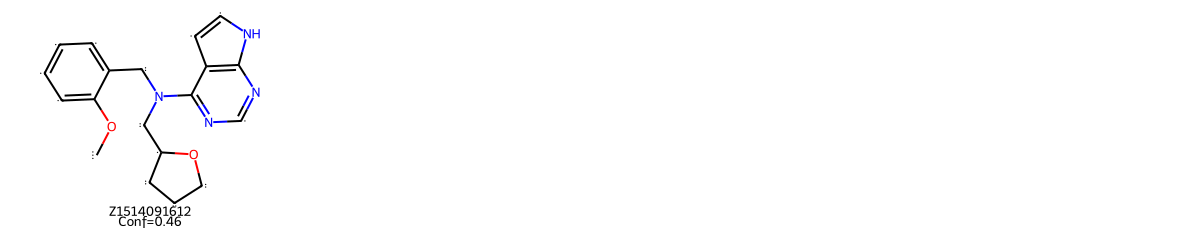


Cluster 13 — 1 members, mean confidence=0.30


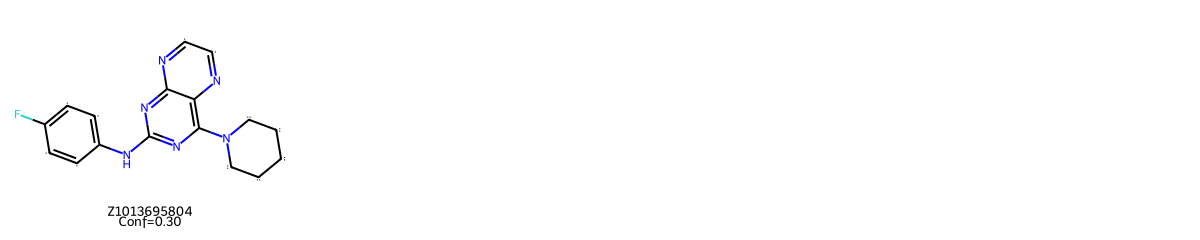


Cluster 14 — 1 members, mean confidence=0.12


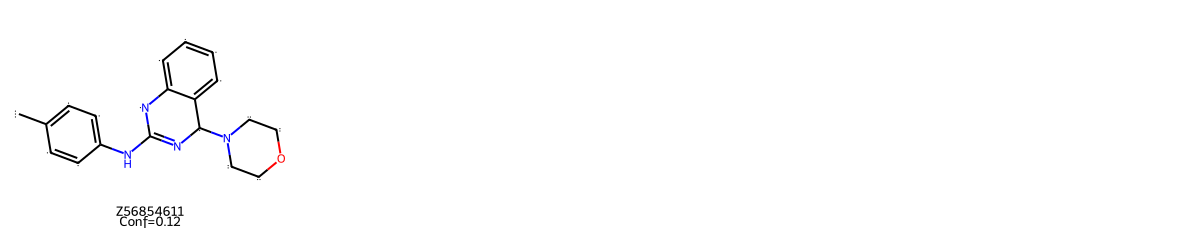


Cluster 15 — 1 members, mean confidence=0.20


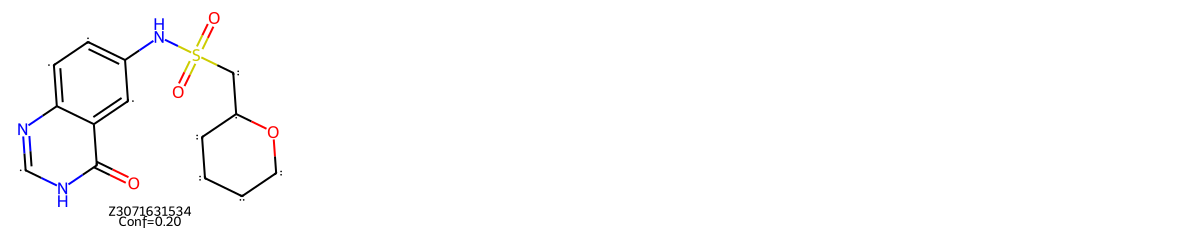

In [11]:
# ---------- 6. Visualize each cluster ----------
for i,cl in enumerate(clusters,1):
    members=top_df.iloc[list(cl)]
    mols_cl=[Chem.MolFromSmiles(s) for s in members.SMILES]
    legends=[f"{cid}\nConf={c:.2f}" for cid,c in zip(members.CID,members.confidence)]
    img=Draw.MolsToGridImage(mols_cl,molsPerRow=4,subImgSize=(300,240),legends=legends)
    print(f"\nCluster {i} — {len(cl)} members, mean confidence={summary_df.loc[i-1,'MeanConf']:.2f}")
    display(img)

In [12]:
# --- Attach cluster IDs to top_df for later reference ---
cluster_ids = {}
for cid, cluster in enumerate(clusters, start=1):
    for idx in cluster:
        cluster_ids[idx] = cid
top_df = top_df.copy()  # ensure we're modifying a standalone DataFrame
top_df.loc[:, "Cluster_ID"] = [cluster_ids.get(i, None) for i in range(len(top_df))]

## **Step 6 — Smart Selection of Top 10 Diverse Ligands**

After clustering, we applied a **data-driven selection strategy** to identify the **10 most promising and diverse ligands**.  
The approach balances chemical diversity, docking confidence, and multi-parameter ADME quality (via the composite **ROC score**).

#### **Selection Logic**
1. **Compute Cluster Statistics:**  
   For each cluster, we calculated:
   - Mean and standard deviation of **ROC_score**
   - Mean and standard deviation of **DiffDock confidence**
   - Cluster size and list of member compounds  

2. **Identify the Best Cluster:**  
   The cluster with the **highest mean ROC_score** was chosen as the “lead cluster.”  
   - If its ROC_score variation (STD_ROC) ≤ 0.05, the two top ligands from this cluster were selected.  
   - Otherwise, only the top-scoring ligand was chosen.

3. **Select Across Clusters:**  
   One top ligand (highest ROC_score) was taken from each of the remaining clusters  
   until the total selection reached 10 unique compounds.

4. **Diversity Balancing:**  
   If fewer than 10 ligands were selected after clustering, the remaining slots were filled  
   with the next best-scoring ligands across all clusters, ensuring a mix of **high ROC_score and chemical variety**.

#### **Output**
- A summary table showing the best-performing clusters and their statistical metrics.  
- A 2D grid visualization of the **10 selected ligands**, annotated with their  
  **ROC score** and **DiffDock confidence** values.

This selection method ensures that the final panel of compounds represents  
**both top predicted binding quality and structural diversity**,  
optimizing the likelihood of identifying distinct, high-quality hits for follow-up.

,Cluster_ID,Num,Mean_ROC,STD_ROC,Mean_Conf,STD_Conf,CIDs
0,4,2,0.663726,0.040736,0.88000,0.050000,"[Z16226176, Z16226232]"
1,15,1,0.603353,0.000000,0.20000,0.000000,[Z3071631534]
2,2,2,0.598118,0.019608,0.01500,0.145000,"[49863194, 49863196]"
3,14,1,0.597133,0.000000,0.12000,0.000000,[Z56854611]
4,13,1,0.585132,0.000000,0.30000,0.000000,[Z1013695804]
5,12,1,0.579486,0.000000,0.46000,0.000000,[Z1514091612]
6,1,8,0.578503,0.024491,0.01125,0.225856,"[COLIG_2A6, 5329551, 4565, 5329558, 5329560, 7..."
7,11,1,0.573782,0.000000,-0.19000,0.000000,[Z2636563025]
8,10,1,0.572879,0.000000,0.32000,0.000000,[Z442313918]
9,3,2,0.570172,0.000463,-0.21000,0.100000,"[5329520, 5329506]"


Best cluster = 4 | Mean ROC=0.664 | STD ROC=0.041 | Mean Conf=0.880 | STD Conf=0.050
Selected from best cluster 4: ['Z16226232']
Final selected 10 molecules:


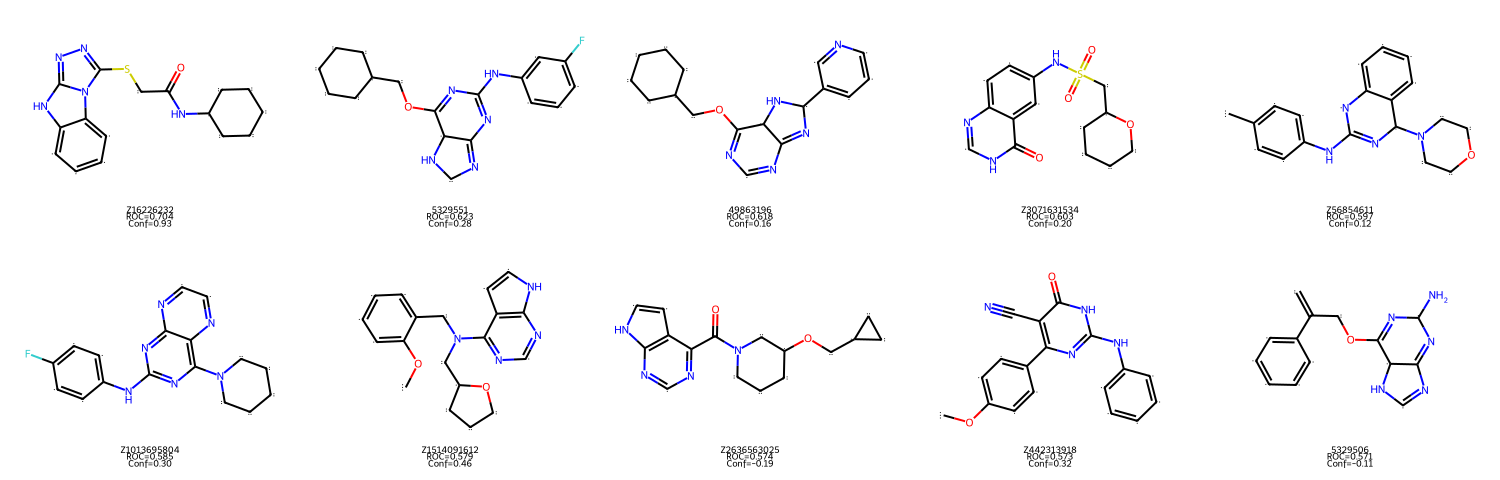

In [13]:
# =====================================================
# Smart selection: top 10 diverse ligands
# =====================================================

MAX_SELECTION = 10
STD_THRESHOLD = 0.05

cluster_stats = []
for i, cl in enumerate(clusters, start=1):
    members = top_df.iloc[list(cl)]
    mean_roc = members["ROC_score"].mean()
    std_roc  = members["ROC_score"].std(ddof=0)
    mean_conf = members["confidence"].mean()
    std_conf  = members["confidence"].std(ddof=0)
    cluster_stats.append({
        "Cluster_ID": i,
        "Num": len(cl),
        "Mean_ROC": mean_roc,
        "STD_ROC": std_roc,
        "Mean_Conf": mean_conf,
        "STD_Conf": std_conf,
        "CIDs": members.CID.tolist()
    })

cluster_df = pd.DataFrame(cluster_stats)
cluster_df = cluster_df.sort_values("Mean_ROC", ascending=False).reset_index(drop=True)
display(cluster_df)

# --- Step 1: identify best cluster (highest mean ROC) ---
best_cluster = cluster_df.iloc[0]
best_cluster_id = int(best_cluster.Cluster_ID)
best_std = best_cluster.STD_ROC
print(f"Best cluster = {best_cluster_id} | Mean ROC={best_cluster.Mean_ROC:.3f} | "
      f"STD ROC={best_std:.3f} | Mean Conf={best_cluster.Mean_Conf:.3f} | "
      f"STD Conf={best_cluster.STD_Conf:.3f}")

# --- Step 2: initialize selection ---
selected_cids = []

# Rule A — take 2 from the best cluster if it's tight, else 1
members = top_df[top_df.Cluster_ID == best_cluster_id].sort_values("ROC_score", ascending=False)
if best_std <= STD_THRESHOLD and len(members) >= 2:
    selected_cids.extend(members.head(1).CID.tolist())
else:
    selected_cids.append(members.iloc[0].CID)
print(f"Selected from best cluster {best_cluster_id}: {selected_cids}")

# Rule B — pick one top ROC member from each remaining cluster, until 10 total
for _, row in cluster_df.iterrows():
    if len(selected_cids) >= MAX_SELECTION:
        break
    cid = int(row.Cluster_ID)
    if cid == best_cluster_id:
        continue
    members = top_df[top_df.Cluster_ID == cid].sort_values("ROC_score", ascending=False)
    if not members.empty:
        selected_cids.append(members.iloc[0].CID)
    if len(selected_cids) >= MAX_SELECTION:
        break

# Rule C — if still <10, fill from top remaining overall
if len(selected_cids) < MAX_SELECTION:
    remaining = top_df[~top_df.CID.isin(selected_cids)]
    remaining_sorted = remaining.sort_values("ROC_score", ascending=False)
    needed = MAX_SELECTION - len(selected_cids)
    selected_cids.extend(remaining_sorted.head(needed).CID.tolist())

# --- Step 3: final selection dataframe ---
selected_cids = list(dict.fromkeys(selected_cids))[:MAX_SELECTION]  # ensure uniqueness and cap
final_df = top_df[top_df.CID.isin(selected_cids)].copy()
final_df = final_df.sort_values("ROC_score", ascending=False).reset_index(drop=True)

print(f"Final selected {len(final_df)} molecules:")
#display(final_df[["CID","Cluster_ID","ROC_score","confidence","LE","QED","logS","nRotB"]])

# --- Visualization ---
mols_sel = [Chem.MolFromSmiles(s) for s in final_df.SMILES]
for m in mols_sel: Chem.rdDepictor.Compute2DCoords(m)
legends = [f"{cid}\nROC={r:.3f}\nConf={c:.2f}"
           for cid,r,c in zip(final_df.CID,final_df.ROC_score,final_df.confidence)]
img = Draw.MolsToGridImage(mols_sel, molsPerRow=5, subImgSize=(300,240), legends=legends)
display(img)

In [15]:
selected_cids

['Z16226232',
 'Z3071631534',
 '49863196',
 'Z56854611',
 'Z1013695804',
 'Z1514091612',
 '5329551',
 'Z2636563025',
 'Z442313918',
 '5329506']

## Overall Summary of Diffdock Virtual Screening :
- The workflow hence selected 10 top ranked diverse set of molecules, with high chance of binding to the same pocket of CDK2 as the co-crystal ligand 2A6.
- The selection criteria also took into account the physicochemical/ADME properties such as :
    - number of bond rotations,
    - TPSA,
    - logP, No. of Hydrogen bond donors and acceptos (included in QED)
    - logS - aqueous solubility
- This resulted in **3/10 compounds from the same chemical series as co-crystal ligand 2A6** which was one of the earlier leads of AstraZeneca in 2002, for CDK2 inhibitors.
- Overall quality of the poses predicted by DiffDock is much better than the Autodock Vina Workflow, although this could be because the training set of DiffDock included the same X-ray structure. 